### **SETUP & IMPORT**

In [ ]:
!pip install transformers[torch]  # Install transformers with PyTorch support
!pip install biopython  # Install Biopython for sequence handling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.7 MB/s eta 0:00:00


In [ ]:
import urllib
from transformers import EsmForSequenceClassification, EsmTokenizer, pipeline
import numpy as np
import pandas as pd
from Bio import SeqIO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving neg_bench.tsv to neg_bench.tsv
Saving neg_train.tsv to neg_train.tsv
Saving negative.fasta to negative.fasta
Saving pos_bench.tsv to pos_bench.tsv
Saving pos_train.tsv to pos_train.tsv
Saving positive.fasta to positive.fasta


### **LOAD AND PREPROCESS THE DATASET**
This block defines the `load_dataset` function, which handles all preprocessing steps for the input protein sequences.
It performs the following operations:

- **Reads the input FASTA file**
- **Parses sequence identifiers and amino acid sequences** using custom text processing.  
- **Filters out empty or invalid sequences** to ensure model compatibility.  
- Returns the dataset in a clean, structured format that can be directly passed to the tokenizer and PyTorch dataloaders.

This process is done for train,validation and test set of both positive and negative sets.

In [ ]:
def load_dataset():
  # Load the TSV file into a DataFrame
  pos_train = pd.read_csv('pos_train.tsv', sep='\t')
  neg_train = pd.read_csv('neg_train.tsv', sep='\t')
  pos_bench = pd.read_csv('pos_bench.tsv', sep='\t')
  neg_bench = pd.read_csv('neg_bench.tsv', sep='\t')

  #Create a customize files for train and val: 1,2,3 train, 4,5 for val
  with open('positive.fasta', 'r') as read:
    with open('train_sp.fasta', 'w') as train:
      with open('val_sp.fasta', 'w') as val:
        for line in read:
          if '>' in line:
            line = line[1:].rstrip()
            query = pos_train.query("seq_id == @line")
            if not query.empty:
              line = read.readline()
              if (query['fold'].iloc[0] == 5) or (query['fold'].iloc[0] == 4):
                print(f">{query['seq_id'].iloc[0]}:1\n{line.rstrip()[:1022]}", file=val)
              else:
                print(f">{query['seq_id'].iloc[0]}:1\n{line.rstrip()[:1022]}", file=train)


  #Create a customize file for the negatives
  with open('negative.fasta', 'r') as read:
    with open('train_sp.fasta', 'a') as train:
      with open('val_sp.fasta', 'a') as val:
        for line in read:
          if '>' in line:
            line = line[1:].rstrip()
            query = neg_train.query("seq_id == @line")
            if not query.empty:
              line = read.readline()
              if (query['fold'].iloc[0] == 5):
                print(f">{query['seq_id'].iloc[0]}:0\n{line.rstrip()[:1022]}", file=val)
              else:
                print(f">{query['seq_id'].iloc[0]}:0\n{line.rstrip()[:1022]}", file=train)


  with open('positive.fasta', 'r') as read:
    with open('test_sp.fasta', 'w') as write:
      for line in read:
        if '>' in line:
          line = line[1:].rstrip()
          query = pos_bench.query("seq_id == @line")
          if not query.empty:
            line = read.readline()
            print(f">{query['seq_id'].iloc[0]}:1\n{line.rstrip()[:1022]}", file=write)


  with open('negative.fasta', 'r') as read:
    with open('test_sp.fasta', 'a') as write:
      for line in read:
        if '>' in line:
          line = line[1:].rstrip()
          query = neg_bench.query("seq_id == @line")
          if not query.empty:
            line = read.readline()
            print(f">{query['seq_id'].iloc[0]}:0\n{line.rstrip()[:1022]}", file=write)

In [ ]:
load_dataset()

In [ ]:
device = "cuda"

### **IMPORT THE ESM MODEL AND TOKENIZER**
- The selected **ESM protein language model** for sequence classification.
- The corresponding tokenizer to convert amino acid sequences into model-readable tokens.


In [ ]:
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
model = EsmForSequenceClassification.from_pretrained(model_name)
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear

### **COMPUTE SEQUENCES EMBEDDING**
The `compute_embeddings` function generates a numerical embedding for a given protein sequence using the pretrained ESM model.  
The function performs the following steps:

- **Tokenizes the input sequence** and converts it into PyTorch tensors compatible with the model.
- **Moves the tensors to the selected device** (CUDA) for faster computation.
- **Runs a forward pass through the model** and retrieves all hidden states from every transformer layer.
- **Extracts embeddings from the last hidden layer**, selecting positions 1 to 90 of the sequence (residues only, excluding special tokens).
- **Returns the resulting embedding matrix**, which can be used for downstream tasks such as classification or similarity analysis.


In [ ]:
# Given a sequence, encode the sequence and extract the embedding
def compute_embeddings(sequence):
  inputs = tokenizer(sequence, return_tensors="pt") #prepare the sequence, return the sequence in a pytorch tensor
  inputs.to(device) #move the tensor in the device
  outputs = model(**inputs, output_hidden_states=True)
  hidden_states = outputs.hidden_states  # Get all hidden states: huge tensor where there are the output of all the 33 layers.
  embeddings = hidden_states[-1][0][1:91,:]  # Extract embeddings from the last layer
  return embeddings

### **EXTRACT INPUT FEATURES (X) AND LABELS (Y)**
The `extract_XY` function processes a FASTA file and generates the dataset used for model training.  
The function performs the following operations:

- **Iterates over each FASTA record** and reads both the amino acid sequence and its associated label (parsed from the FASTA header).
- **Computes the embedding of each sequence** using the pretrained ESM model:
  - The sequence is tokenized and moved to the selected device (GPU/CPU).
  - A forward pass is executed to retrieve all hidden states.
  - **Embeddings are extracted from the last hidden layer**, selecting only the residue positions (1–90).
- **Applies mean pooling:** each sequence embedding is averaged across residues to obtain a fixed-size feature vector.
- **Stores the resulting embedding vectors** into `M` (input features) and the labels into `Y`.
- **Periodically prints progress** (every 100 sequences) to monitor long processing runs.
- **Frees GPU memory** by deleting intermediate tensors after each iteration.
- **Returns two NumPy arrays:**  
  - `M` containing the averaged embeddings (X)  
  - `Y` containing the corresponding labels  


In [ ]:
def extract_XY(file):
    # avarage embeddings
    M = []
    # Labels
    Y = []
    # for the avarage pooling
    i = 0

    for record in SeqIO.parse(file, "fasta"):
        i += 1
        sequence = str(record.seq)
        y = record.id.split(":")[1]
        Y.append(y)  # Store the label

        # Process embeddings in smaller steps
        with torch.no_grad():  # No need for gradient tracking
            inputs = tokenizer(sequence, return_tensors="pt")  # Prepare the sequence tensor
            inputs.to(device)  # Move to GPU

            # Run the model and get hidden states
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            embeddings = hidden_states[-1][0][1:91, :]  # Extract last layer embeddings

            # Detach, transfer to CPU, and convert to numpy for averaging
            mean_embedding = np.mean(embeddings.detach().cpu().numpy(), axis=0)
            M.append(mean_embedding)
            if i%100==0:
              print(i)

            # Clear cache to avoid memory buildup
            del inputs, outputs, hidden_states, embeddings  # Free up memory
            #torch.cuda.empty_cache()  # Clear cached memory

    return np.array(M), np.array(Y)

In [ ]:
test_M, test_Y = extract_XY("test_sp.fasta")
print(f'Test:\nM={test_M.shape}, Y={test_Y.shape}')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Test:
M=(2006, 1280), Y=(2006,)


In [ ]:
train_M, train_Y = extract_XY("train_sp.fasta")
print(f'Train:\nM={train_M.shape}, Y={train_Y.shape}')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
Train:
M=(6243, 1280), Y=(6243,)


In [ ]:
val_M, val_Y = extract_XY("val_sp.fasta")
print(f'Validation:\nM={val_M.shape}, Y={val_Y.shape}')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
Validation:
M=(1778, 1280), Y=(1778,)


### **DEFINE THE MLP MODEL**
This block sets up the components required for training and evaluating a fully connected neural network on the protein embeddings.

#### Model definition  
The `SP_MLP` class implements a multi-layer perceptron (MLP) with:
- Four fully connected layers (`fc1` → `fc4`)
- ReLU activations after each hidden layer
- Dropout regularization to reduce overfitting
- A final softmax layer for multi-class classification  
The architecture is configurable through the number of hidden units and the dropout probability.

#### Custom dataset  
The `SPMLP_Dataset` class converts:
- The input embeddings (`X`) into PyTorch tensors  
- The string labels (`y`) into numerical class indices  
This dataset structure allows the model to train on averaged protein embeddings produced earlier.

#### Evaluation function  
The `test` function evaluates the trained model on a test set by:
- Switching the model to evaluation mode  
- Performing forward passes without gradient computation  
- Computing predictions and comparing them to true labels  
- Reporting multiple metrics:  
  **accuracy, precision, recall, F1-score, MCC**, and the **confusion matrix**  
All evaluation results are also written to an output file.

#### Device setup  
The cell concludes by selecting the appropriate device (GPU if available, otherwise CPU) and printing the choice.


In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the model
class SP_MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_p=0.5):
        super(SP_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_p)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out

# Define a custom dataset
class SPMLP_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        # Convert string labels to numerical labels to have categorical labels
        unique_labels = np.unique(y)
        label_mapping = {label: i for i, label in enumerate(unique_labels)}
        labels = np.array([label_mapping[label] for label in y])
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def test(model, test_loader, scorer = matthews_corrcoef, output_transform = lambda x: torch.argmax(x, dim=1)):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
      for batch_X, batch_y in test_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device)
          outputs = model(batch_X)
          preds = output_transform(outputs)
          all_preds.extend(preds.cpu().numpy().flatten())
          all_labels.extend(batch_y.cpu().numpy().flatten()) # Fixed: Removed output_transform from batch_y

  score = scorer(all_labels, all_preds)
  accuracy = accuracy_score(all_labels, all_preds)
  mcc = matthews_corrcoef(all_labels, all_preds)
  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  cm = confusion_matrix(all_labels, all_preds)
  print('Test score: {:.4f}'.format(score))
  with open('DL_bench_res.txt', 'w') as write:
    print(f'Confusion Matrix:\n{cm}', file=write)
    print('Accuracy: '+str(accuracy)+'\nPrecision: '+str(precision)+'\nRecall: '+str(recall)+'\nF1 Score: '+str(f1)+'\nMCC: '+str(mcc)+'\n', file=write)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


### **TRAINING LOOP WITH EARLY STOPPING**

This block defines the full training procedure for the MLP model, including validation monitoring and early stopping, as well as a helper function for plotting training curves.

#### Training and validation (`train_val_print`)
The `train_val_print` function performs the following steps:

- **Initializes tracking variables** for losses, best validation score, and early stopping.
- **Iterates through training epochs**, performing:
  - Mini-batch training with forward pass, loss computation, backpropagation, and optimizer updates.
  - Calculation of the **average training loss** for each epoch.
- **Runs validation at the end of each epoch**:
  - Disables gradient computation for efficiency.
  - Computes validation loss and predictions.
  - Evaluates model performance using a chosen metric (default: **Matthews Correlation Coefficient, MCC**).
- **Early stopping**:
  - The model keeps track of the best validation score seen so far.
  - If the score does not improve for a number of consecutive epochs equal to `patience`, training stops early.
  - When an improvement is detected, the **best model weights** are saved.

The function returns:
- The **state dictionary of the best-performing model**
- The list of **training losses**
- The list of **validation losses**

#### Visualization (`plot_loss_curves`)
This helper function generates a plot of the training and validation loss across epochs, allowing visual inspection of learning dynamics and potential overfitting.


In [ ]:
def train_val_print(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  train_mccs = []
  val_mccs = []
  train_f1s = []
  val_f1s = []
  train_precisions = []
  val_precisions = []
  train_recalls = []
  val_recalls = []

  best_val_score = -1
  epochs_without_improvement = 0
  best_model_state_dict = None

  for epoch in range(epochs):
      # Training
      model.train()
      running_train_loss = 0.0

      for batch_X, batch_y in train_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device) #transfer the batch
          optimizer.zero_grad() #set up the gradient

          outputs = model(batch_X)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step() #update the parameters

          running_train_loss += loss.item()

      # Compute average training loss for the epoch
      avg_train_loss = running_train_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # Evaluate on training set after each epoch
      _, train_accuracy, train_mcc, train_precision, train_recall, train_f1, _, _ = evaluate_model(model, train_loader, criterion, device)
      train_accuracies.append(train_accuracy)
      train_mccs.append(train_mcc)
      train_f1s.append(train_f1)
      train_precisions.append(train_precision)
      train_recalls.append(train_recall)

      # Validation
      model.eval()
      avg_val_loss, val_accuracy, val_mcc, val_precision, val_recall, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)

      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)
      val_mccs.append(val_mcc)
      val_f1s.append(val_f1)
      val_precisions.append(val_precision)
      val_recalls.append(val_recall)

      # Use MCC for early stopping
      val_score = val_mcc

      if val_score > best_val_score:
          best_val_score = val_score
          epochs_without_improvement = 0
          best_model_state_dict = model.state_dict()
          print('Validation MCC improved to {:.4f}'.format(best_val_score))
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              print('Early stopping at epoch {}'.format(epoch+1))
              break

      print('Epoch [{}/{}], Train Loss: {:.4f}, Train MCC: {:.4f}, Train Precision: {:.4f}, Train Recall: {:.4f}, Val Loss: {:.4f}, Val MCC: {:.4f}, Val Precision: {:.4f}, Val Recall: {:.4f}'.format(
          epoch+1, epochs, avg_train_loss, train_mcc, train_precision, train_recall, avg_val_loss, val_mcc, val_precision, val_recall))

  return best_model_state_dict, train_losses, val_losses, train_accuracies, val_accuracies, train_mccs, val_mccs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls

# Plotting the training and validation loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

### **MODEL EVALUATION**
This function evaluates a trained model on a given dataset. It performs the following steps:

- Switches the model to evaluation mode and disables gradient computation.
- Iterates over the dataloader to:
  - Compute the loss for each batch.
  - Generate predictions using the model’s output.
- Collects all predictions and true labels to compute:
  - The **average loss** across the dataset.
  - The evaluation metric specified by `scorer` (e.g., MCC).
- Returns the average loss, the performance score, and the full lists of labels and predictions.


In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            # Calculation of loss
            loss = criterion(outputs, batch_y)
            running_loss += loss.item()

            # Predictions for the score
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return avg_loss, accuracy, mcc, precision, recall, f1, all_labels, all_preds

### **MLP FINAL PIPELINE**

This block outlines the process of training, validating, and testing a **MLP (Multi-Layer Perceptron)** model.
The main steps are:

1. **Loading and preparing the dataset**  
   - `X_train`, `y_train`: training data and labels  
   - `X_val`, `y_val`: validation data and labels  
   - `X_test`, `y_test`: test data and labels  
   - Data are wrapped in custom `Dataset` objects and loaded via `DataLoader` with a batch size of 16.

2. **Defining the MLP model**  
   - Architecture with **3 hidden layers** of 40 neurons each  
   - Activation function: **ReLU** (presumably implemented inside `SP_MLP`)  
   - Dropout: `p=0.25` to reduce overfitting  
   - Output layer with 2 neurons for binary classification

3. **Loss function and optimizer**  
   - Loss: `CrossEntropyLoss`  
   - Optimizer: `Adam`

4. **Training with early stopping**  
   - Maximum epochs: 100  
   - Early stopping patience: 10 epochs  
   - Best model weights are saved based on validation performance

5. **Testing the model**  
   - Evaluation on the test set using **Matthews Correlation Coeffic**


In [ ]:
# Load the dataset
X_train, y_train, X_test, y_test, X_val, y_val = train_M, train_Y, test_M, test_Y, val_M, val_Y
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("-" * 50)

# Split the dataset into training, validation and test sets
train_dataset = SPMLP_Dataset(X_train, y_train)
val_dataset = SPMLP_Dataset(X_val, y_val)
test_dataset = SPMLP_Dataset(X_test, y_test)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 40
hidden_size2 = 40
hidden_size3 = 40
output_size = 2
dropout_p = 0.25
model = SP_MLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_p=dropout_p)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

# Train the model with early stopping
epochs = 100
patience = 10

best_model_state_dict, train_losses, val_losses, train_accuracies, val_accuracies, train_mccs, val_mccs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_val_print(model, train_loader, val_loader, optimizer, criterion, epochs, patience)
model.load_state_dict(best_model_state_dict)

# Testing
test(model, test_loader, scorer=matthews_corrcoef)

X_train shape: (6243, 1280)
y_train shape: (6243,)
X_test shape: (2006, 1280)
y_test shape: (2006,)
X_val shape: (1778, 1280)
y_val shape: (1778,)
--------------------------------------------------
Validation MCC improved to 0.6622
Epoch [1/100], Train Loss: 0.4111, Train MCC: 0.6889, Train Precision: 0.9851, Train Recall: 0.5048, Val Loss: 0.4117, Val MCC: 0.6622, Val Precision: 1.0000, Val Recall: 0.4928
Validation MCC improved to 0.9659
Epoch [2/100], Train Loss: 0.3350, Train MCC: 0.9613, Train Precision: 0.9710, Train Recall: 0.9581, Val Loss: 0.3253, Val MCC: 0.9659, Val Precision: 0.9853, Val Recall: 0.9599
Validation MCC improved to 0.9787
Epoch [3/100], Train Loss: 0.3210, Train MCC: 0.9683, Train Precision: 0.9574, Train Recall: 0.9848, Val Loss: 0.3200, Val MCC: 0.9787, Val Precision: 0.9773, Val Recall: 0.9885
Validation MCC improved to 0.9804
Epoch [4/100], Train Loss: 0.3188, Train MCC: 0.9773, Train Precision: 0.9719, Train Recall: 0.9867, Val Loss: 0.3191, Val MCC: 0.98

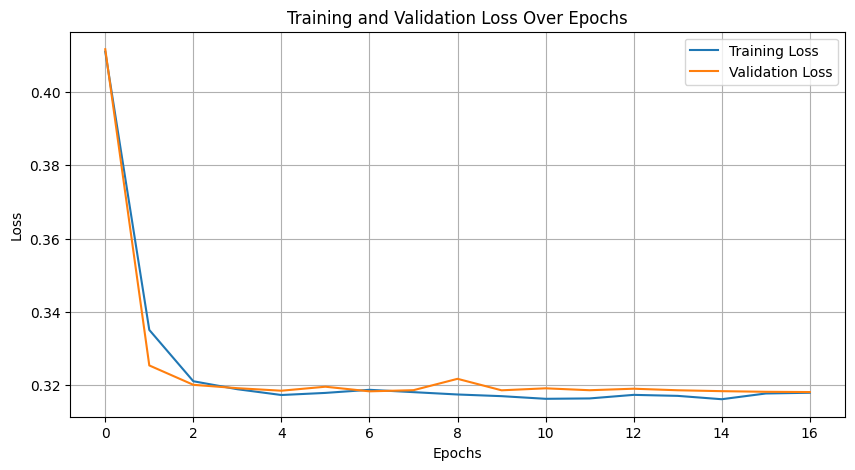

In [ ]:
plot_loss_curves(train_losses, val_losses)

# **HYPERPARAMETERS OPTIMIZATION WITH OPTUNA**

This section uses **Optuna** to optimize the hyperparameters of the MLP model for better validation performance.  

**Steps:**

1. **Define the objective function**  
   - Suggest hyperparameters:
     - Hidden layer sizes: `hidden_size1`, `hidden_size2`, `hidden_size3` (32–50 neurons)  
     - Dropout probability: `dropout_p` (0.1–0.5)  
     - Learning rate: `lr` (log-uniform between 1e-5 and 1e-2)  
   - Instantiate the `SP_MLP` model with suggested hyperparameters  
   - Define optimizer (`Adam`) with the suggested learning rate  
   - Train the model using early stopping (`train_val_print`)  
   - Evaluate the model on the validation set using **Matthews Correlation Coefficient (MCC)**

2. **Create and run an Optuna study**  
   - Objective: **maximize MCC on the validation set**  
   - Number of trials: `n_trials=10` (can be adjusted)  

3. **Output results**  
   - Best hyperparameter combination (`study.best_params`)  
   - Corresponding best validation score (`study.best_value`)  

This approach automates the search for the optimal combination of hyperparameters to improve model generalization.


In [ ]:
!pip install optuna
import optuna

def objective(trial):
    # Suggest values for the hyperparameters
    hidden_size1 = trial.suggest_int('hidden_size1', 32, 50)
    hidden_size2 = trial.suggest_int('hidden_size2', 32, 50)
    hidden_size3 = trial.suggest_int('hidden_size3', 32, 50)
    dropout_p = trial.suggest_float('dropout_p', 0.1, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    # Create the model with these hyperparameters
    model = SP_MLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_p=dropout_p)
    model.to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model with early stopping (e.g., using your `train_val` function)
    best_model_state_dict, _, _, _, val_accuracies, _, val_mccs, _, val_f1s, val_precisions, val_recalls, _, _ = train_val_print(model, train_loader, val_loader, optimizer, criterion, epochs, patience)

    # Load the best model for evaluation
    model.load_state_dict(best_model_state_dict)

    # Return the best validation MCC for optimization
    # Assuming val_mccs contains MCCs for all epochs, and the best_model_state_dict corresponds to the best MCC
    # We need to re-evaluate the model with the best_model_state_dict on the validation set to get the exact best MCC if it wasn't the last epoch.
    model.eval()  # Set the model to evaluation mode
    avg_val_loss, val_accuracy, val_mcc, val_precision, val_recall, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)

    return val_mcc  # Return the validation MCC for optimization

# Create an Optuna study to maximize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can adjust n_trials as needed

# Print the best hyperparameters and score
print("Best hyperparameters:", study.best_params)
print("Best validation score:", study.best_value)

[I 2025-11-20 16:25:19,412] A new study created in memory with name: no-name-75806e7d-8b36-488d-8fa1-b4772e782bb2
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4040, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-11-20 16:26:02,738] Trial 0 finished with value: 0.0 and parameters: {'hidden_size1': 39, 'hidden_size2': 36, 'hidden_size3': 47, 'dropout_p': 0.32665173967406735, 'lr': 0.002234216793660955}. Best is trial 0 with value: 0.0.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0

Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4132, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000
Validation MCC improved to 0.9588
Epoch [5/100], Train Loss: 0.3897, Train MCC: 0.9608, Train Precision: 0.9568, Train Recall: 0.9714, Val Loss: 0.3726, Val MCC: 0.9588, Val Precision: 0.9766, Val Recall: 0.9570
Epoch [6/100], Train Loss: 0.3271, Train MCC: 0.9590, Train Precision: 0.9783, Train Recall: 0.9467, Val Loss: 0.3260, Val MCC: 0.9569, Val Precision: 0.9851, Val Recall: 0.9456
Validation MCC improved to 0.9858
Epoch [7/100], Train Loss: 0.3218, Train MCC: 0.9704, Train Precision: 0.9576, Train Recall: 0.9886, Val Loss: 0.3176, Val MCC: 0.9858, Val Precision: 0.9830, Val Recall: 0.9943
Epoch [8/100], Train Loss: 0.3197, Train MCC: 0.9719, Train Precision: 0.9752, Train Recall: 0.9733, Val Loss: 0.3214, Val MCC: 0.9732, Val Precision: 0.9827, Val Recall: 0.9742
Epoch [9/100], Train Loss: 0.3192, Train M

[I 2025-11-20 16:26:47,542] Trial 1 finished with value: 0.9767398026475391 and parameters: {'hidden_size1': 46, 'hidden_size2': 32, 'hidden_size3': 39, 'dropout_p': 0.3600834117773174, 'lr': 0.0009725870188677103}. Best is trial 1 with value: 0.9767398026475391.


Early stopping at epoch 24


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4156, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000
Validation MCC improved to 0.9131
Epoch [3/100], Train Loss: 0.3922, Train MCC: 0.9089, Train Precision: 0.9641, Train Recall: 0.8705, Val Loss: 0.3879, Val MCC: 0.9131, Val Precision: 0.9871, Val Recall: 0.8739
Validation MCC improved to 0.9770
Epoch [4/100], Train Loss: 0.3285, Train MCC: 0.9581, Train Precision: 0.9465, Train Recall: 0.9771, Val Loss: 0.3201, Val MCC: 0.9770, Val Precision: 0.9746, Val Recall: 0.9885
Epoch [5/100], Train Loss: 0.3213, Train MCC: 0.9639, Train Precision: 0.9605, Train Recall: 0.9733, Val Loss: 0.3203, Val MCC: 0.9733, Val Precision: 0.9771, Val Recall: 0.9799
Validation MCC improved to 0.9804
Epoch [6/100], Train Loss: 0.3196, Train MCC: 0.9763, Train Precision: 0.9718, Train Recall: 0.9848, Val Loss: 0.3199, Val MCC: 0.9804, Val Precision: 0.9829, Val Recall: 0.9857
Epoch [7

[I 2025-11-20 16:27:35,898] Trial 2 finished with value: 0.9803420507709031 and parameters: {'hidden_size1': 45, 'hidden_size2': 38, 'hidden_size3': 34, 'dropout_p': 0.32547442875960775, 'lr': 0.0005497259331649674}. Best is trial 2 with value: 0.9803420507709031.


Early stopping at epoch 33


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4001, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-11-20 16:27:49,986] Trial 3 finished with value: 0.0 and paramete

Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4118, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.3971, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-11-20 16:28:06,583] Trial 4 finished with value: 0.0 and paramete

Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4196, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5078, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3903, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.4073, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000
Validation MCC improved to 0.9752
Epoch [3/100], Train Loss: 0.3277, Train MCC: 0.9643, Train Precision: 0.9520, Train Recall: 0.9829, Val Loss: 0.3203, Val MCC: 0.9752, Val Precision: 0.9745, Val Recall: 0.9857
Validation MCC improved to 0.9767
Epoch [4/100], Train Loss: 0.3203, Train MCC: 0.9740, Train Precision: 0.9753, Train Recall: 0.9771, Val Loss: 0.3209, Val MCC: 0.9767, Val Precision: 0.9884, Val Recall: 0.9742
Validation MCC improved to 0.9803
Epoch [5/100], Train Loss: 0.3184, Train MCC: 0.9782, Train Precision: 0.9773, Train Recall: 0.9829, Val Loss: 0.3199, Val MCC: 0.9803, Val Precision: 0.9884, Val Recall: 0.9799
Epoch [6/100], Train Loss: 0.3179, Train MCC: 0.9772, Train Precision: 0.9754, Train Recall: 0.9829, Val Loss: 0.3192, Val MCC: 0.9803, Val Precision: 0.9884, Val Recall: 0.9799
Validati

[I 2025-11-20 16:28:51,918] Trial 5 finished with value: 0.9821220459059156 and parameters: {'hidden_size1': 34, 'hidden_size2': 46, 'hidden_size3': 42, 'dropout_p': 0.24443129284996323, 'lr': 0.0004416110176423806}. Best is trial 5 with value: 0.9821220459059156.


Early stopping at epoch 32


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.6492, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.6145, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.4833, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5116, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.4125, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5066, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.4016, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5067, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Train Loss: 0.3994, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5071, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Train Loss: 0.3984, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5073, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Train Loss: 0.3978, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5074, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Train Loss: 0.3975, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5075, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Train Loss: 0.3974, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5074, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.3971, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5073, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-11-20 16:29:05,584] Trial 6 finished with value: 0.0 and paramete

Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4187, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5079, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000
Validation MCC improved to 0.9714
Epoch [2/100], Train Loss: 0.3840, Train MCC: 0.9605, Train Precision: 0.9638, Train Recall: 0.9638, Val Loss: 0.3689, Val MCC: 0.9714, Val Precision: 0.9798, Val Recall: 0.9742
Validation MCC improved to 0.9807
Epoch [3/100], Train Loss: 0.3249, Train MCC: 0.9655, Train Precision: 0.9488, Train Recall: 0.9886, Val Loss: 0.3202, Val MCC: 0.9807, Val Precision: 0.9721, Val Recall: 0.9971
Epoch [4/100], Train Loss: 0.3198, Train MCC: 0.9742, Train Precision: 0.9682, Train Recall: 0.9848, Val Loss: 0.3204, Val MCC: 0.9786, Val Precision: 0.9856, Val Recall: 0.9799
Epoch [5/100], Train Loss: 0.3186, Train MCC: 0.9750, Train Precision: 0.9790, Train Recall: 0.9752, Val Loss: 0.3221, Val MCC: 0.9713, Val Precision: 0.9883, Val Recall: 0.9656
Epoch [6

[I 2025-11-20 16:29:29,537] Trial 7 finished with value: 0.985714864543295 and parameters: {'hidden_size1': 49, 'hidden_size2': 41, 'hidden_size3': 42, 'dropout_p': 0.26189605727619997, 'lr': 0.0006223341477028767}. Best is trial 7 with value: 0.985714864543295.


Early stopping at epoch 19


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.4010, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Train Loss: 0.3979, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.3972, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5080, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-11-20 16:29:43,253] Trial 8 finished with value: 0.0 and paramete

Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation MCC improved to 0.0000
Epoch [1/100], Train Loss: 0.7061, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.6860, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Train Loss: 0.6515, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.6275, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/100], Train Loss: 0.5590, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5549, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/100], Train Loss: 0.4742, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5181, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/100], Train Loss: 0.4355, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5087, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/100], Train Loss: 0.4170, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5068, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Train Loss: 0.4085, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5067, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Train Loss: 0.4047, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5069, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Train Loss: 0.4024, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5071, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.4007, Train MCC: 0.0000, Train Precision: 0.0000, Train Recall: 0.0000, Val Loss: 0.5073, Val MCC: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-11-20 16:29:56,891] Trial 9 finished with value: 0.0 and paramete

Early stopping at epoch 11
Best hyperparameters: {'hidden_size1': 49, 'hidden_size2': 41, 'hidden_size3': 42, 'dropout_p': 0.26189605727619997, 'lr': 0.0006223341477028767}
Best validation score: 0.985714864543295


### **FINAL MODEL TRAINING**
This section performs the **final training** of the MLP model using the previously defined best hyperparameters and training settings.

- **Training process:**  
  - Reuses `epochs` and `patience` for early stopping.  
  - Uses the custom training function `train_val_print` (or an updated version such as `train_with_early_stopping`) to train the model on the training set and validate on the validation set.  

- **Early stopping:**  
  - Tracks validation performance (MCC) during training.  
  - Saves the model weights corresponding to the best validation score.  

- **Loading the best model:**  
  - After training, the model is loaded with the **best weights** found during validation.  
  - Ensures that the model is in its optimal state for final evaluation or deployment.  




In [ ]:
best_state_dict, train_losses, val_losses, train_accuracies, val_accuracies, train_mccs, val_mccs, train_f1s, val_f1s, train_precisions, val_precisions, train_recalls, val_recalls = train_val_print(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs,
    patience
)

# Load the state of the weights that gave the best MCC on the Validation Set
model.load_state_dict(best_state_dict)

print("\nFinal training completed and best state loaded.")

# Print the final metrics for training and validation
print(f"\nFinal Training Metrics:")
print(f"  Accuracy: {train_accuracies[-1]:.4f}")
print(f"  Precision: {train_precisions[-1]:.4f}")
print(f"  Recall: {train_recalls[-1]:.4f}")
print(f"  F1-Score: {train_f1s[-1]:.4f}")
print(f"  MCC: {train_mccs[-1]:.4f}")

print(f"\nFinal Validation Metrics:")
print(f"  Accuracy: {val_accuracies[-1]:.4f}")
print(f"  Precision: {val_precisions[-1]:.4f}")
print(f"  Recall: {val_recalls[-1]:.4f}")
print(f"  F1-Score: {val_f1s[-1]:.4f}")
print(f"  MCC: {val_mccs[-1]:.4f}")

Validation MCC improved to 0.9875
Epoch [1/100], Train Loss: 0.3171, Train MCC: 0.9844, Train Precision: 0.9830, Train Recall: 0.9886, Val Loss: 0.3173, Val MCC: 0.9875, Val Precision: 0.9886, Val Recall: 0.9914
Epoch [2/100], Train Loss: 0.3164, Train MCC: 0.9855, Train Precision: 0.9848, Train Recall: 0.9886, Val Loss: 0.3185, Val MCC: 0.9821, Val Precision: 0.9885, Val Recall: 0.9828
Epoch [3/100], Train Loss: 0.3165, Train MCC: 0.9835, Train Precision: 0.9793, Train Recall: 0.9905, Val Loss: 0.3175, Val MCC: 0.9857, Val Precision: 0.9885, Val Recall: 0.9885
Epoch [4/100], Train Loss: 0.3172, Train MCC: 0.9835, Train Precision: 0.9793, Train Recall: 0.9905, Val Loss: 0.3175, Val MCC: 0.9857, Val Precision: 0.9885, Val Recall: 0.9885
Epoch [5/100], Train Loss: 0.3164, Train MCC: 0.9855, Train Precision: 0.9830, Train Recall: 0.9905, Val Loss: 0.3187, Val MCC: 0.9821, Val Precision: 0.9913, Val Recall: 0.9799
Epoch [6/100], Train Loss: 0.3166, Train MCC: 0.9844, Train Precision: 0.983

In [ ]:
# Test set final evaluation
test(model, test_loader, scorer=matthews_corrcoef)

Test score: 0.9560
